Colaboratoryのサンプルを加工してテキストファイルの分類を行ってみます。

# Colaboratoryのサンプルを加工してテキストファイルの分類を行ってみます。

# CalculiXとOpenFoamのファイル確認

# CalculiXとOpenFoamのファイル群の二つを用いて、二項分類器をトレーニングします。

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [3]:
print(tf.__version__)

2.9.0-dev20220328


## 文書フォーマットの分析

もともとは映画レビューの感情分析ですが、解析ファイルのフォーマット違いによる分類へ適用してみます。


### サンプルファイルを収集してセットする

CalculiXとOpenFoamのサンプルファイルを学習用に用意します。
集めたらフォルダに格納します。

In [4]:
#作業に従ったフォルダにします。
dataset_dir = 'C:\Work\HP3\\tensorflow\TA13\\files'

In [5]:
os.listdir(dataset_dir)

['test', 'train']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['ccx', 'openfoam']

`files\train\ccx` および `files\train\openfoam` ディレクトリには多くのテキストファイルが含まれており、設定ファイルによってフォーマットはまちまちだったりします。

In [ ]:
sample_file = os.path.join(train_dir, 'openfoam\\basic\chtMultiRegionFoam\\2DImplicitCyclic\system\controlDict.txt')
with open(sample_file) as f:
  print(f.read())

### データセットを読み込む

次に、データを読み込み、トレーニングに適した形式に準備します。これを行うには、便利な [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) ユーティリティを使用します。このユーティリティは、次のようなディレクトリ構造を想定しています。

```
files/train/
...ccx/
......beamnlptp.dat.txt
......beamnlptp.txt
```
...openfoam/
......combustion/
```
......epsilon1.txt
```
OpenFoamはサブフォルダがあります。

CCXとOpenfoamのファイル拡張子を.txtにします。
単独で機能させるためにimport osを付けています。

In [ ]:
import os

folder = 'files'

for root, dirs, files in os.walk(folder):
    for filename in files:
        print(os.path.join(root, filename))

        bufOri = filename
        filename, file_extension = os.path.splitext(filename)
        # if file_extension !='.txt':
        try:
            new_file_name = filename + '.txt'
            os.rename(os.path.join(root, bufOri), os.path.join(root, new_file_name))
        except:
            # Handle or ignore the error
            pass

次に、`text_dataset_from_directory` ユーティリティを使用して、ラベル付きの `tf.data.Dataset` を作成します。[tf.data](https://www.tensorflow.org/guide/data) は、データを操作するための強力なツールのコレクションです。

機械学習実験を実行するときは、データセットを[トレーニング]、[検証]、および、[テスト]の 3 つに分割することをお勧めします。

IMDB データセットはすでにトレーニング用とテスト用に分割されていますが、検証セットはありません。以下の `validation_split` 引数を使用して、トレーニングデータの 80:20 分割を使用して検証セットを作成しましょう。

"tf.keras.preprocessing.text_dataset_from_directory"は、TensorFlowのKerasライブラリに含まれる関数で、テキストデータを読み込んでDatasetオブジェクトに変換するために使用されます。この関数は、サブディレクトリがテキストデータのカテゴリ/クラスに対応するように保存されたテキストファイルを読み込むためのものです。この関数は、トレーニングに使用できるDatasetオブジェクトを返します。

この関数は、データの読み込みと処理の方法を制御するための様々なパラメータを使用することができます。これらのパラメータには次のようなものがあります：

directory: テキストファイルが保存されているディレクトリへのパス。

labels: 各テキストファイルに関連付けられたラベル（サブディレクトリ名からラベルへのマッピングを含む辞書）。

batch_size: Dataset内の各バッチに含まれるサンプル数。

shuffle: エポックごとにデータをシャッフルするかどうか。

text_encoding: テキストファイルに使用されるエンコーディング。

全体的に、"tf.keras.preprocessing.text_dataset_from_directory"は、テキストデータの読み込みと前処理を容易にする便利な関数であり、テキストベースの機械学習モデルのトレーニングのプロセスを簡素化することができます。

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'files/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 2629 files belonging to 2 classes.
Using 2104 files for training.


上記のように、トレーニングフォルダには 2629 の例があり、そのうち 80％ (2104) をトレーニングに使用します。以下に示すとおり、データセットを `model.fit` に直接渡すことで、モデルをトレーニングできます。`tf.data` を初めて使用する場合は、データセットを繰り返し処理して、次のようにいくつかの例を出力することもできます。

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

ラベルは 0 または 1 です。これらのどれがCCXかOpenFoamのファイルであるかを確認するには、データセットの `class_names` プロパティを確認できます。


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to ccx
Label 1 corresponds to openfoam


次に、検証およびテスト用データセットを作成します。トレーニング用セットの残りの 525 ファイルを検証に使用します。

注意:  `validation_split` および `subset` 引数を使用する場合は、必ずランダムシードを指定するか、`shuffle=False` を渡して、検証とトレーニング分割に重複がないようにします。

In [54]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'files/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 2629 files belonging to 2 classes.
Using 525 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'files/test', 
    batch_size=batch_size)

Found 1029 files belonging to 2 classes.


### トレーニング用データを準備する

次に、便利な `tf.keras.layers.TextVectorization` レイヤーを使用して、データを標準化、トークン化、およびベクトル化します。

標準化とは、テキストを前処理することを指します。通常、句読点や HTML 要素を削除して、データセットを簡素化します。トークン化とは、文字列をトークンに分割することです (たとえば、空白で分割することにより、文を個々の単語に分割します)。ベクトル化とは、トークンを数値に変換して、ニューラルネットワークに入力できるようにすることです。これらのタスクはすべて、このレイヤーで実行できます。


注意: [トレーニング/テストスキュー](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)（トレーニング/サービングスキューとも呼ばれます）を防ぐには、トレーニング時とテスト時にデータを同じように前処理することが重要です。これを容易にするためには、このチュートリアルの後半で示すように、`TextVectorization` レイヤーをモデル内に直接含めます。

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

次に、`TextVectorization` レイヤーを作成します。このレイヤーを使用して、データを標準化、トークン化、およびベクトル化します。`output_mode` を `int` に設定して、トークンごとに一意の整数インデックスを作成します。

デフォルトの分割関数と、上記で定義したカスタム標準化関数を使用していることに注意してください。また、明示的な最大値 `sequence_length` など、モデルの定数をいくつか定義します。これにより、レイヤーはシーケンスを正確に `sequence_length` 値にパディングまたは切り捨てます。

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

次に、`adapt` を呼び出して、前処理レイヤーの状態をデータセットに適合させます。これにより、モデルは文字列から整数へのインデックスを作成します。

注意: Adapt を呼び出すときは、トレーニング用データのみを使用することが重要です（テスト用セットを使用すると情報が漏洩します）。

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

このレイヤーを使用して一部のデータを前処理した結果を確認する関数を作成します。

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'species\n(\n    O2\n    H2O\n    CH4\n    CO2\n    N2\n);\n\nreactions\n{\n    methaneReaction\n    {\n        type irreversibleinfiniteReaction;\n        reaction "CH4 + 2O2 + 7.52N2 = CO2 + 2H2O + 7.52N2";\n    }\n}\n', shape=(), dtype=string)
Label openfoam
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1, 1088, 1253, 2285, 2222,  545,    1,    1,   48,    1,  411,
        2285,    1,    1, 2222,    1,    1,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,

上記のように、各トークンは整数に置き換えられています。レイヤーで `.get_vocabulary()` を呼び出すことにより、各整数が対応するトークン（文字列）を検索できます。

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  1717
 313 --->  145
Vocabulary size: 10000


モデルをトレーニングする準備がほぼ整いました。最後の前処理ステップとして、トレーニング、検証、およびデータセットのテストのために前に作成した TextVectorization レイヤーを適用します。

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### パフォーマンスのためにデータセットを構成する

以下は、I/O がブロックされないようにするためにデータを読み込むときに使用する必要がある 2 つの重要な方法です。

`.cache()` はデータをディスクから読み込んだ後、データをメモリに保持します。これにより、モデルのトレーニング中にデータセットがボトルネックになることを回避できます。データセットが大きすぎてメモリに収まらない場合は、この方法を使用して、パフォーマンスの高いオンディスクキャッシュを作成することもできます。これは、多くの小さなファイルを読み込むより効率的です。

`.prefetch()` はトレーニング中にデータの前処理とモデルの実行をオーバーラップさせます。

以上の 2 つの方法とデータをディスクにキャッシュする方法についての詳細は、[データパフォーマンスガイド](https://www.tensorflow.org/guide/data_performance)を参照してください。

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### モデルを作成する

ニューラルネットワークを作成します。

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

これらのレイヤーは、分類器を構成するため一列に積み重ねられます。

1. 最初のレイヤーは `Embedding` （埋め込み）レイヤーです。このレイヤーは、整数にエンコードされた語彙を受け取り、それぞれの単語インデックスに対応する埋め込みベクトルを検索します。埋め込みベクトルは、モデルのトレーニングの中で学習されます。ベクトル化のために、出力行列には次元が１つ追加されます。その結果、次元は、`(batch, sequence, embedding)` となります。埋め込みの詳細については、[単語埋め込みチュートリアル](https://www.tensorflow.org/text/guide/word_embeddings)を参照してください。
2. 次は、`GlobalAveragePooling1D`（１次元のグローバル平均プーリング）レイヤーです。このレイヤーは、それぞれのサンプルについて、シーケンスの次元方向に平均値をもとめ、固定長のベクトルを返します。この結果、モデルは最も単純な形で、可変長の入力を扱うことができるようになります。
3. この固定長の出力ベクトルは、16 個の非表示ユニットを持つ全結合 (`Dense`) レイヤーに受け渡されます。
4. 最後のレイヤーは、単一の出力ノードと密に接続されています。

### 損失関数とオプティマイザ

モデルをトレーニングするには、損失関数とオプティマイザが必要です。これは二項分類問題であり、モデルは確率（シグモイドアクティベーションを持つ単一ユニットレイヤー）を出力するため、`losses.BinaryCrossentropy` 損失関数を使用します。

損失関数の候補はこれだけではありません。例えば、`mean_squared_error`（平均二乗誤差）を使うこともできます。しかし、一般的には、確率を扱うには`binary_crossentropy`の方が適しています。`binary_crossentropy`は、確率分布の間の「距離」を測定する尺度です。今回の場合には、真の分布と予測値の分布の間の距離ということになります。

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### モデルをトレーニングする

`dataset` オブジェクトを fit メソッドに渡すことにより、モデルをトレーニングします。

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
66/66 [==============================] - 12s 156ms/step - loss: 0.6546 - binary_accuracy: 0.7747 - val_loss: 0.6037 - val_binary_accuracy: 0.8133
Epoch 2/10
66/66 [==============================] - 1s 9ms/step - loss: 0.5572 - binary_accuracy: 0.8270 - val_loss: 0.5036 - val_binary_accuracy: 0.8324
Epoch 3/10
66/66 [==============================] - 1s 10ms/step - loss: 0.4719 - binary_accuracy: 0.8313 - val_loss: 0.4293 - val_binary_accuracy: 0.8457
Epoch 4/10
66/66 [==============================] - 1s 9ms/step - loss: 0.4156 - binary_accuracy: 0.8379 - val_loss: 0.3831 - val_binary_accuracy: 0.8495
Epoch 5/10
66/66 [==============================] - 1s 9ms/step - loss: 0.3817 - binary_accuracy: 0.8446 - val_loss: 0.3512 - val_binary_accuracy: 0.8533
Epoch 6/10
66/66 [==============================] - 1s 10ms/step - loss: 0.3543 - binary_accuracy: 0.8522 - val_loss: 0.3251 - val_binary_accuracy: 0.8686
Epoch 7/10
66/66 [==============================] - 1s 8ms/step - loss:

### モデルを評価する

モデルがどのように実行するか見てみましょう。2 つの値が返されます。損失（誤差、値が低いほど良）と正確度です。

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

33/33 [==============================] - 3s 79ms/step - loss: 0.1857 - binary_accuracy: 0.9524
Loss:  0.18569868803024292
Accuracy:  0.9523809552192688


この、かなり素朴なアプローチでも 95% 前後の正解度を達成しました。

### 経時的な正解度と損失のグラフを作成する

`model.fit()` は、トレーニング中に発生したすべての情報を詰まったディクショナリを含む `History` オブジェクトを返します。

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

トレーニングと検証中に監視されている各メトリックに対して 1 つずつ、計 4 つのエントリがあります。このエントリを使用して、トレーニングと検証の損失とトレーニングと検証の正解度を比較したグラフを作成することができます。

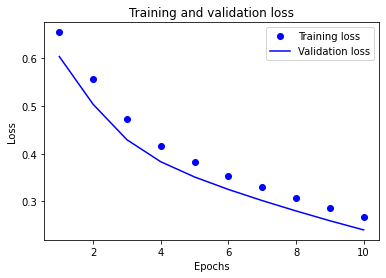

In [55]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

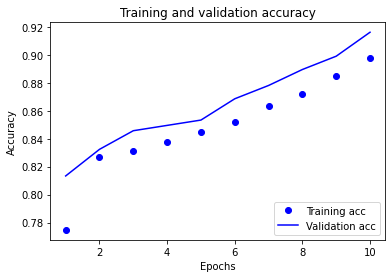

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

このグラフでは、点はトレーニングの損失と正解度を表し、実線は検証の損失と正解度を表します。


特定のケースでは、検証の正解度が向上しなくなったときにトレーニングを停止することにより、過適合を防ぐことができます。これを行うには、`tf.keras.callbacks.EarlyStopping` コールバックを使用することができます。

## モデルをエクスポートする

上記のコードでは、モデルにテキストをフィードする前に、`TextVectorization` レイヤーをデータセットに適用しました。モデルで生の文字列を処理できるようにする場合 (たとえば、展開を簡素化するため)、モデル内に `TextVectorization` レイヤーを含めることができます。これを行うには、トレーニングしたばかりの重みを使用して新しいモデルを作成します。

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

33/33 [==============================] - 2s 51ms/step - loss: 0.1857 - accuracy: 0.9524
0.9523809552192688


### 新しいデータの推論

新しい例の予測を取得するには、`model.predict()`を呼び出します。

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 237ms/step


array([[0.8058029],
       [0.8058029],
       [0.8058029]], dtype=float32)

In [53]:
# checkFile = 'check\\beam_bar_r1.inp'
checkFile = 'check\A711_2_sample\system\controlDict'

with open(checkFile, 'r') as file:
    content = file.read()
    # print(content)

examples = [
content
]

export_model.predict(examples)
buf1= export_model.predict(examples)

print(checkFile)
print(buf1[0])


1/1 [==============================] - 0s 148ms/step
check\A711_2_sample\system\controlDict
[0.87956655]
